In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pprint

from qiskit import pulse, QuantumCircuit, transpile, IBMQ
from qiskit import schedule as build_schedule
from qiskit.circuit import Parameter
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization.pulse_v2 import IQXDebugging
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibmq_montreal')

In [3]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()

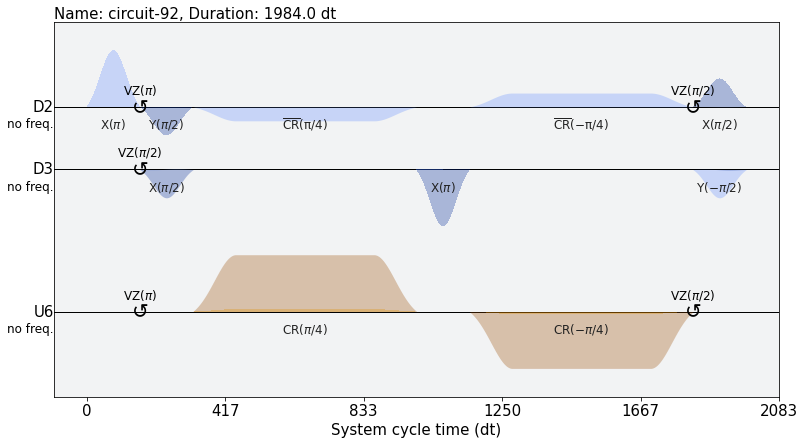

In [8]:
circuit = QuantumCircuit(2)
circuit.x(0)
circuit.cx(0, 1)

circuit = transpile(circuit, backend=backend, initial_layout=[2, 3])
schedule = build_schedule(circuit, backend=backend)

#pprint.pprint(schedule.instructions)
schedule.draw()

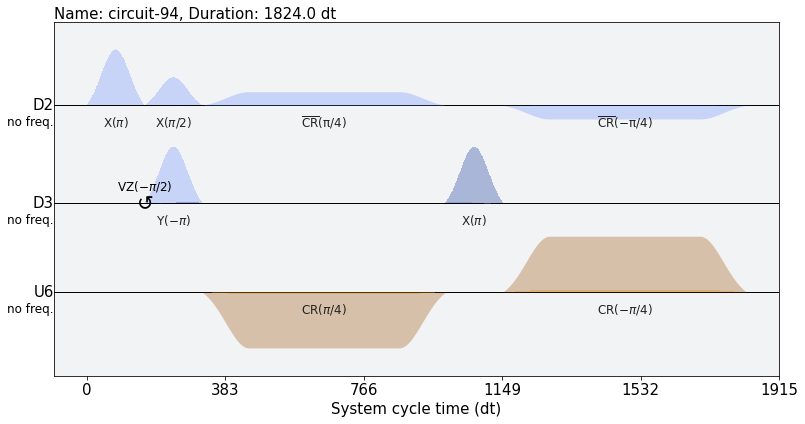

In [9]:
circuit = QuantumCircuit(2)
circuit.x(0)
circuit.cx(1, 0)

circuit = transpile(circuit, backend=backend, initial_layout=[2, 3])
schedule = build_schedule(circuit, backend=backend)

#pprint.pprint(schedule.instructions)
schedule.draw()

In [5]:
dt = backend_config.dt

In [6]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
control_qubit = 1
target_qubit = 0
# We will define memory slot channel 0.
control_mem_slot = 1
target_mem_slot = 0

In [7]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [8]:
# Rabi experiment parameters
num_rabi_points = 10

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0.
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

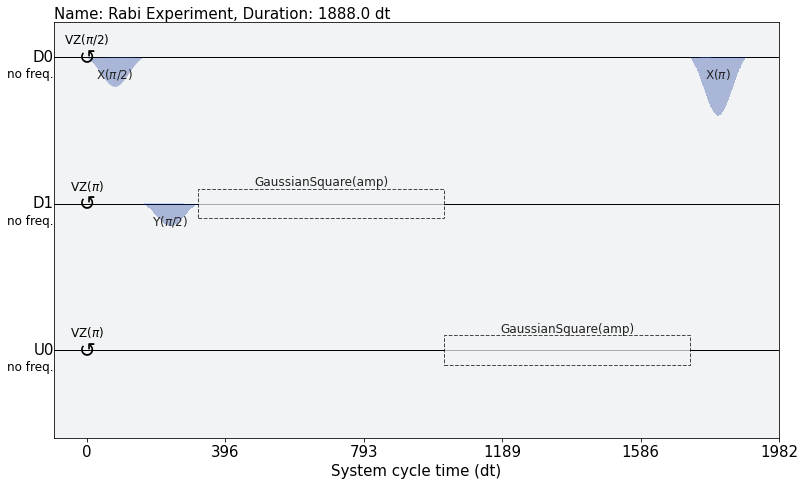

In [22]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

control_drive_amp = Parameter('control_drive_amp')
target_drive_amp = Parameter('target_drive_amp')
control_drive_amp_full = 0.044099368914567484+0.0018657898747177582j
target_drive_amp_full = -0.0850506321021275+0.23522423937540576j

#with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched_0:
#    control_chan = pulse.control_channels(control_qubit, target_qubit)[0]
#    #pulse.set_frequency(backend_defaults.qubit_freq_est[target_qubit], control_chan)
#    pulse.play(pulse.GaussianSquare(duration=1152, amp=drive_amp, sigma=64, width=896, name='CR90p_u0'), control_chan, name='CR90p_u0')
#    pulse.measure(qubits=[control_qubit, target_qubit], registers=[pulse.MemorySlot(control_mem_slot), pulse.MemorySlot(target_mem_slot)])

with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched_0:
    drive_chan_control = pulse.drive_channel(control_qubit)
    drive_chan_target = pulse.drive_channel(target_qubit)
    #control_chan = pulse.control_channels(control_qubit, target_qubit)[0]
    control_chan = pulse.ControlChannel(0)
    
    pulse.shift_phase(-np.pi * 0.5, drive_chan_target)
    pulse.shift_phase(-np.pi, drive_chan_control)
    pulse.shift_phase(-np.pi, control_chan)
    pulse.play(pulse.Drag(duration=160, amp=(0.09150828002779902+0.0014973530604975597j), sigma=40, beta=-0.5857110768929772, name='X90p_d0'), drive_chan_target, name='X90p_d0')
    pulse.play(pulse.Drag(duration=160, amp=(-0.0008057417396462386+0.09584090556037655j), sigma=40, beta=0.29520073469507346, name='Y90p_d1'), drive_chan_control, name='Y90p_d1')
    pulse.play(pulse.GaussianSquare(duration=704, amp=control_drive_amp, sigma=64, width=448, name='CR90p_d1_u0'), drive_chan_control, name='CR90p_d1_u0')
    pulse.play(pulse.GaussianSquare(duration=704, amp=target_drive_amp, sigma=64, width=448, name='CR90p_u0'), control_chan, name='CR90p_u0')
    pulse.play(pulse.Drag(duration=160, amp=(0.18322927401482877+0j), sigma=40, beta=-0.6305021018851894, name='Xp_d0'), drive_chan_target, name='Xp_d0')
    
rabi_sched_0.draw()

#TODO NEED TO SHIFT THE CONTROL GAUSSIANSQUARE BACKß

In [9]:
x_sched = backend_defaults.instruction_schedule_map.get('x', [control_qubit])

with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched_1:
    drive_chan = pulse.drive_channel(control_qubit)
    control_chan = pulse.control_channels(control_qubit, target_qubit)[0]
    #pulse.set_frequency(backend_defaults.qubit_freq_est[target_qubit], control_chan)
    #rabi_sched_1 += play_x
    pulse.call(x_sched)
    #pulse.delay(x_sched.duration, control_chan)
    pulse.play(pulse.GaussianSquare(duration=1152, amp=drive_amp, sigma=64, width=896, name='CR90p_u0'), control_chan, name='CR90p_u0')
    pulse.measure(qubits=[control_qubit, target_qubit], registers=[pulse.MemorySlot(control_mem_slot), pulse.MemorySlot(target_mem_slot)])
    
rabi_schedules_0 = [rabi_sched_0.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]
rabi_schedules_1 = [rabi_sched_1.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

In [10]:
pprint.pprint(rabi_schedules_0[0].instructions)
pprint.pprint(rabi_schedules_1[0].instructions)

((0,
  Play(GaussianSquare(duration=1152, amp=0j, sigma=64, width=896, name='CR90p_u0'), ControlChannel(1), name='CR90p_u0')),
 (1152, Acquire(13440, AcquireChannel(0), MemorySlot(0))),
 (1152, Acquire(13440, AcquireChannel(1), MemorySlot(1))),
 (1152,
  Play(GaussianSquare(duration=13440, amp=(0.031134604748959863+0.08444309555627416j), sigma=64, width=13184, name='M_m0'), MeasureChannel(0), name='M_m0')),
 (1152,
  Play(GaussianSquare(duration=13440, amp=(-0.02317394001087012+0.03857419479875883j), sigma=64, width=13184, name='M_m1'), MeasureChannel(1), name='M_m1')),
 (14592, Delay(9968, MeasureChannel(0))),
 (14592, Delay(9968, MeasureChannel(1))))
((0,
  Call(Schedule((0, Play(Drag(duration=160, amp=(0.19218758972518335+0j), sigma=40, beta=0.28886522680641613, name='Xp_d1'), DriveChannel(1), name='Xp_d1')), name="x"), name='call_x')),
 (160,
  Play(GaussianSquare(duration=1152, amp=0j, sigma=64, width=896, name='CR90p_u0'), ControlChannel(1), name='CR90p_u0')),
 (1312, Acquire(134

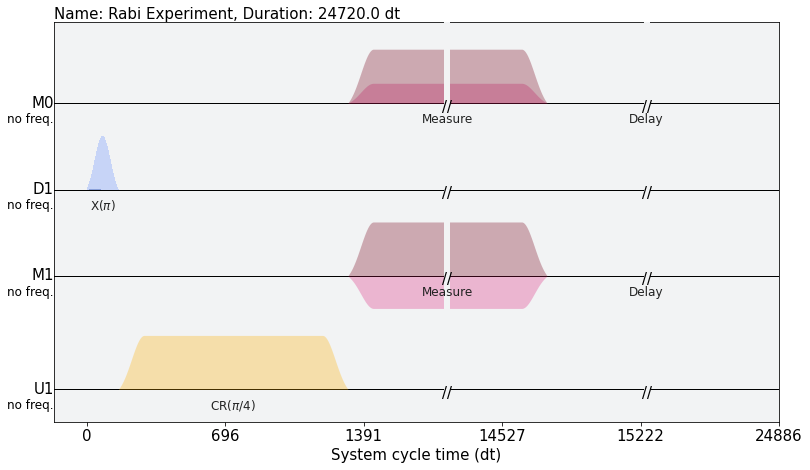

In [11]:
rabi_schedules_1[-1].draw()

In [12]:
num_shots_per_point = 1024

job_0 = backend.run(rabi_schedules_0, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_1 = backend.run(rabi_schedules_1, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

/usr/local/lib/python3.8/dist-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


In [13]:
job_monitor(job_0)
job_monitor(job_1)

Job Status: job has successfully run
Job Status: job has successfully run


In [14]:
rabi_results_0 = job_0.result(timeout=120)
rabi_results_1 = job_1.result(timeout=120)

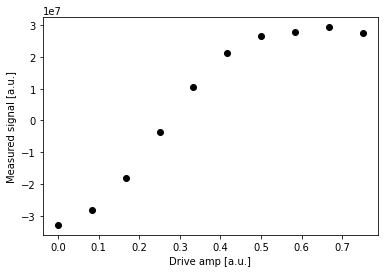

In [15]:
rabi_values_0 = np.empty(num_rabi_points, dtype=np.float)
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values_0[i] = rabi_results_0.get_memory(i)[target_mem_slot].real

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values_0, color='black') # plot real part of Rabi values
plt.show()

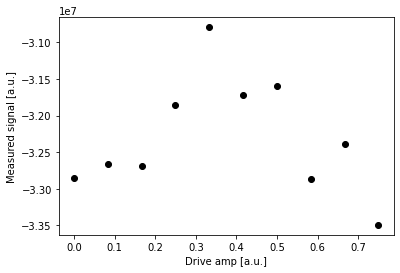

In [16]:
rabi_values_1 = np.empty(num_rabi_points, dtype=np.float)
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values_1[i] = rabi_results_1.get_memory(i)[target_mem_slot].real

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values_1, color='black') # plot real part of Rabi values
plt.show()

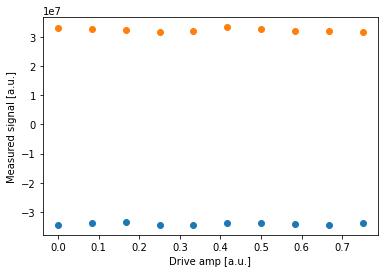

In [18]:
rabi_values_0 = np.array([rabi_results_0.get_memory(i)[control_mem_slot].real for i in range(num_rabi_points)])
rabi_values_1 = np.array([rabi_results_1.get_memory(i)[control_mem_slot].real for i in range(num_rabi_points)])

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values_0)
plt.scatter(drive_amps, rabi_values_1)
plt.show()